# Advanced Modelling using Pre-trained Object Detection Models

In this notebook I use a pre-trained object detection model from the TensorFlow Hub. The object detection model uses faster RCNN and InceptionResNet V2. This model was recommended by the TensorFlow Object Detecction Guide.

The model provides a bounding box with dimensions around common objects in an image. The model was trained on images similar enough to the objects in my dataset to extract useful information about the dimensions of the food items in my dataset. I then use other objects in the image such as a human hand or plate to estimate the dimensions of the food item, approximate the volume of the item and finally calculate the calories.

The result of this notebook is an image with accompanying bounding boxes, annotations describing the item used for reference and the approximate calories in the food item.

I start by loading in the necessary Python packages:

In [17]:
# Standard packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Print Tensorflow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.15.0


I am mounting my google drive here to run the code on Google Colab.

In [18]:
# Mount my drive to access dataset
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Function Definitions

### Display Image

This function is simply used to display the final image.

In [19]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

### Draw Bounding Box on Image

This function is used to draw the bounding box and ensure that the text is wrapped such that it shows within the dimensions of the original image.

In [20]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  """Function from TensorFlow Guide. Adds a bounding box to an image."""

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

### Get Dimensions

This function is used to determine which of the objects in the detected items list can be used for reference and which is the target object that I eventually want to calculate the calories for. This function is called in the Get Calories function.

In [31]:
def get_dims(boxes, class_names, scores, max_boxes, min_score):
    '''
    Inputs: boxes - a list of x and y dimensions
            class_names - a list of class names detected
            scores - a list of confidence scores
            max_boxes - the maximum number of objects whose dimensions are needed
            min_score - the minimum confidence score to calculate dimensions

    Outputs: reference_item - a string corresponding to the reference item with the highest confidence.
            food_item - a string corresponding to the first food item detected.
            dimensions - a dictionary with keys as the class names and values
                       corresponding to the x and y dimensions in the image
    '''

    dimensions = {}
    food_classes = ["Apple", "Tomato", "Egg", "Orange", "Kiwi", "Onion",
                    "Pepper", "Banana", "Cucumber", "Carrot",
                    "Beans", "Pasta", "Watermelon", "Grapes",
                    "Bread", "Cheese"]

    reference_items = ["Plate", "Human hand"]
    reference_item = None
    food_item = None

    for i, detected_items in enumerate(class_names):

        score = scores[i]
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        class_name = detected_items.decode("ascii")

        # Check if the class is in the list of food classes
        if class_name in food_classes and class_name not in dimensions and food_item is None:
            food_item = class_name
            dimensions[class_name] = [(xmax - xmin), (ymax - ymin)]

        # Check for reference items
        if class_name in reference_items and reference_item is None:
            reference_item = class_name
            dimensions[class_name] = [(xmax - xmin), (ymax - ymin)]

        if len(dimensions) >= len(reference_items) + 1:  # +1 for food_item
            break

    print(f"Found reference item: {reference_item}")

    for class_name in dimensions.keys():
        if reference_item:
            print(f"Calculated x-dimensions for {class_name}: {dimensions[class_name][0]} and y-dimensions for {class_name}: {dimensions[class_name][1]}")

    return reference_item, food_item, dimensions


### Get Volume

This function is used to approximate the volume of the food item using the items passed through by the get dimensions function. It will use the reference item with the highest confidence score passed into the function.

The function bins the food items into common 3D shapes in order to approximate the volume. These shapes are spheres, cylinders, discs and rectangular prisms. Discs and cylinders are distinguished by which face was used for the cross sectional area calculation.

**The output of this function is the volume of the food item in cubic centimetres.**

In [35]:
def get_volume(reference, food, dimensions):

  '''

  Inputs: dimesnions - a dictionary with keys as the class names and values
                       corresponding to the x and y dimensions in the image

  Outputs: volume - an estimation for the volume of the food item in cm^3

  This function approximates the real volume of a food item in the image
  by assuming a constant dimension for a reference item in the photo, the
  plate. Using the dimensions from the bounding box annotation of the plate
  in the imag, a reference ratio is calculated. The referece ratio is used
  to scale the cross-sectional area of the food item. Finally, the volume
  is calculated by multiplying this scaled area with the item's depth.

  '''

  # Approximate food volume shapes
  spheres = ["Apple", "Tomato", "Egg", "Orange", "Kiwi", "Onion", "Pepper"]
  cylinders = ["Banana", "Cucumber", "Carrot"]
  discs = ["Beans", "Pasta", "Watermelon", "Grapes"]
  prisms =["Bread","Cheese"]

  if reference == "Plate":
    # Assume a reference value for the actual area for the plate
    # Common circular plate size diamter is 30cm
    PLATE_RADIUS = 30/2
    actual_area = np.pi*PLATE_RADIUS**2

    # Calculate the plate area in the photo
    img_plate_radius = np.mean(dimensions[reference])/2
    img_area = np.pi*img_plate_radius**2

  # Might have more confidence in the human hand for reference, use:
  if reference == "Human hand":
    actual_area = 130
    img_area = dimensions[reference][0]*dimensions[reference][1]

  #Using the food area in the photo:
  # acutal food area = food photo area * (actual ref area / photo ref area)
  # actual food area = food photo area * reference ratio
  reference_ratio = actual_area/img_area

  # Calculate the food area in the photo
  if food in spheres:
    radius = np.mean(dimensions[food])
    img_food_area = np.pi*radius**2
    actual_food_area = reference_ratio*img_food_area
    # volume = (4/3)*np.pi*radius**3
    # = (4/3)*radius*(np.pi*radius**2) = (4/3)*radius*actual_food_area
    volume = (4/3)*radius*actual_food_area

  if food in cylinders:
    height = max(dimensions[food])
    radius = min(dimensions[food])/2
    img_food_area = height*radius
    actual_food_area = reference_ratio*img_food_area
    # volume = np.pi*height*radius**2
    # = (1/2*)np.pi*radius*(2*radius*height) = (1/2*)np.pi*radius*actual_food_area
    volume = (1/2)*np.pi*radius*actual_food_area

  if food in discs:
    # Discs are cylinders but cross section area is circle not rectangle
    height = 5
    radius = np.mean(dimensions[food])/2
    img_food_area = np.pi*radius**2
    actual_food_area = reference_ratio*img_food_area
    # volume = np.pi*height*radius**2
    # = height*(np.pi*radius**2) = height*actual_food_area
    volume = height*actual_food_area

  if food in prisms:

    img_food_area = dimensions[food][0]*dimensions[food][1]*0.75
    actual_food_area = reference_ratio*img_food_area

    if food == "Bread":
      height = 2
      volume = height*actual_food_area

    if food == "Cheese":
      height = 1
      volume = height*actual_food_area

    print(f"Calculated the area to be: {actual_food_area} cm^2")

  return round(volume,2)

### Get Calories

This function is used to calculate the calories of the food item with the highest score detected by the model. It uses a nested dictionary of caloric and density values that I obtained from the USDA website and inputted manually. Ideally there would be a CSV with tabulated values for the density and calories per 100g that I could read in using Pandas. This will suffice for now.

The output of this function is used in the draw boxes function to label the food item with the calorie count.

In [23]:
def get_calories(boxes, class_names, scores, max_boxes, min_score):

  '''
	Inputs: volume - float value in units of cm^3
          food - string for the name of the food item

	Uses a list food densities and caloric values to calculate the calories
  of a food item.
	'''

  # Calories per 100g of my food classes
  # Densities in g/cm^3

  # needs food item and volume from prev functions

  reference, food, dimensions = get_dims(boxes, class_names, scores, max_boxes, min_score)

  volume = get_volume(reference, food, dimensions)

  # source: https://www.ars.usda.gov/arsuserfiles/80400525/data/hg72/hg72_2002.pdf
  nutrition_values = {
      "Apple": {"density": 0.609, "calories": 52},
      "Banana": {"density": 0.94, "calories": 89},
      "Beans": {"density": 0.577, "calories": 92},
      "Carrot": {"density": 0.641, "calories": 41},
      "Cheese": {"density": 1.151, "calories": 360},
      "Orange": {"density": 0.482, "calories": 47},
      "Onion": {"density": 0.513, "calories": 40},
      "Pasta": {"density": 0.641, "calories": 158},
      "Tomato": {"density": 0.481, "calories": 18},
      "Cucumber": {"density": 0.641, "calories": 16},
      "Grapes": {"density": 0.521, "calories": 72},
      "Kiwi": {"density": 0.881, "calories": 61},
      "Pepper": {"density": 0.288, "calories": 31},
      "Egg": {"density": 1.086, "calories": 156},
      "Bread": {"density": 0.25, "calories":260},
      "Watermelon": {"density": 0.65, "calories": 30}
  }

  # in grams
  mass = volume*nutrition_values[food]["density"]
  calories = round(nutrition_values[food]["calories"]/100*mass,2)

  return food, calories

### Draw Boxes

This function is used to attach the correcting labels to the detected items. It will indrectly call of the previous functions through the get_calories call and assumes that only 2 objects will be passed in.

The output of this function is the labeled image that can be used with the final Run Detector function.

In [24]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=2, min_score=0.2):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              50)

  food, calories = get_calories(boxes, class_names, scores, max_boxes, min_score)

  for i in range(min(boxes.shape[0], max_boxes)):

    if scores[i] >= min_score:

      ymin, xmin, ymax, xmax = tuple(boxes[i])

      if food == class_names[i].decode("ascii"):
        display_str = "{}: {} calories".format(class_names[i].decode("ascii"),
                                      int(calories))
      else:
        display_str = "{}: Reference".format(class_names[i].decode("ascii"))

      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image

## Apply the Pre-trained model to Show Results


Here I am selecting which pre-trained model to use. As mentioned in the introduction, I am using Faster RCNN + InceptionResNet V2. Other combinations of models are commented beside the one that is used. Each model has advantages and disadvantages. The one I am using has a very high accuracy but requires ~ 1-2 minutes to make an inference on my image. There is a trade-off between speed and accuracy which would have to be assessed if this method was used in production.

For demonstration purposes I want to use the highest accuracy possible.

In [39]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

This function is used to load an image from my Google Drive into a format that can be used by the model.

In [26]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

### Run Detector Function

This is the final function defined in this notebook. It uses all of the functions in this notebook to run the object detection model, find the reference, calculate the calories and label the items accordingly.

In [27]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)

  result = {key:value.numpy() for key,value in result.items()}

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

  return result

This is where I select which image to use:

In [37]:
drivepath = "/content/drive/MyDrive/DSData/FooDD/Apple(33).jpg"

# "/content/drive/MyDrive/DSData/FooDD/1 (54).jpg" - uses the hand as reference

#"/content/drive/MyDrive/DSData/FooDD/Apple(33).jpg" - uses the plate as reference


This final line runs the detector function.

Found reference item: Plate
Calculated x-dimensions for Plate: 0.7687160968780518 and y-dimensions for Plate: 1.0
Calculated x-dimensions for Apple: 0.2759610414505005 and y-dimensions for Apple: 0.4544884264469147


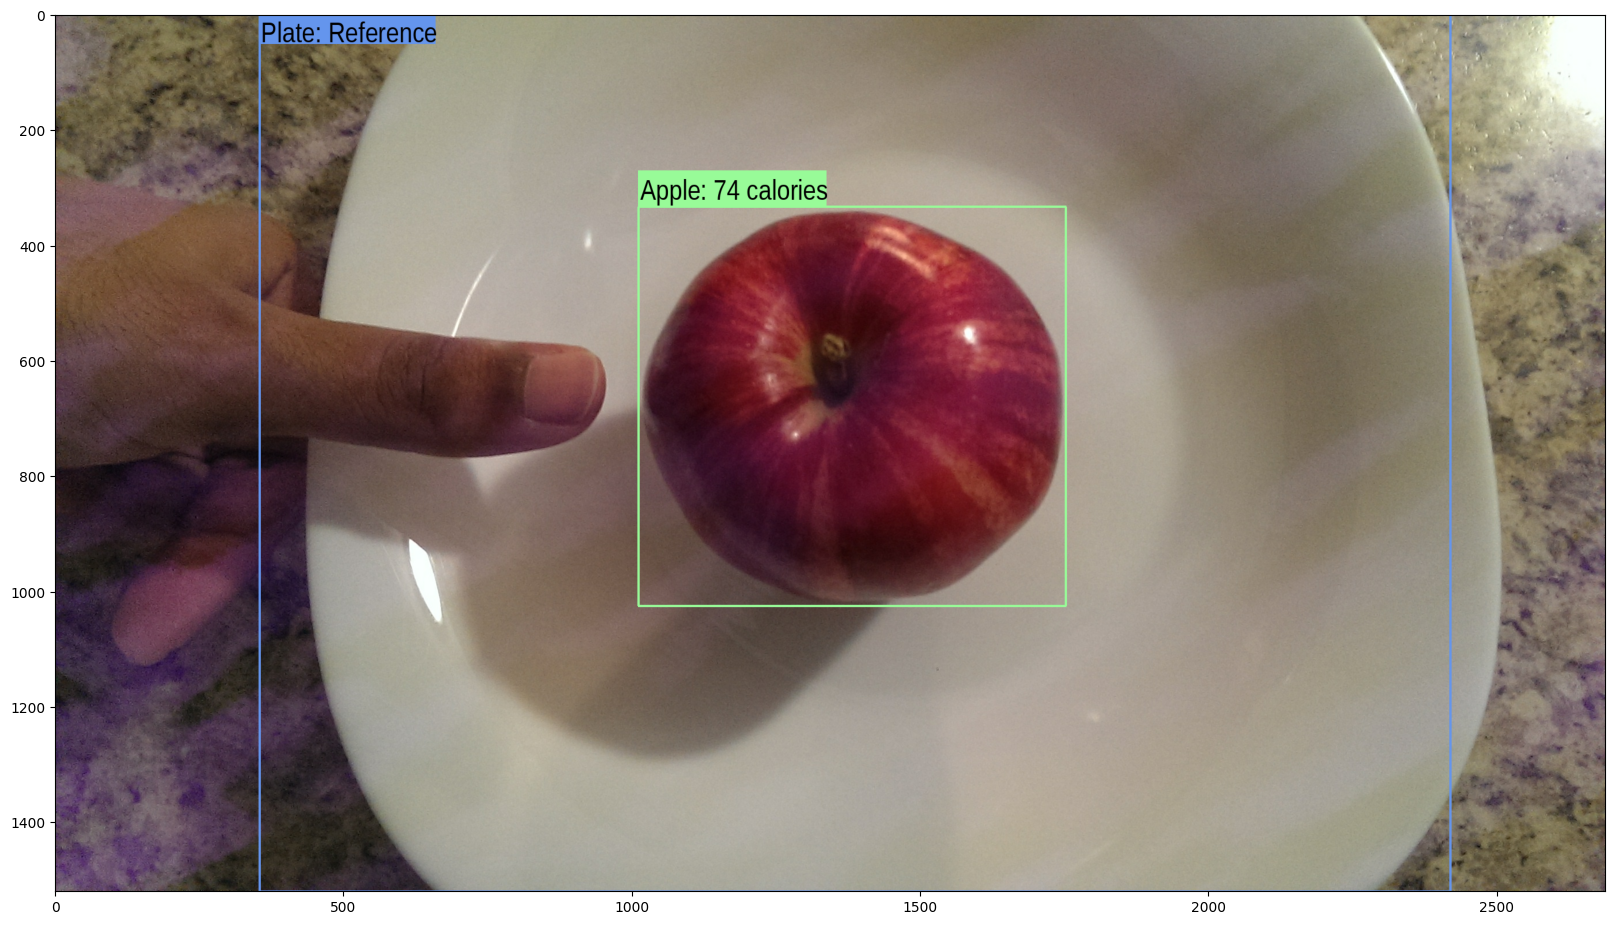

In [38]:
# Run the detector on my image from dataset
result = run_detector(detector,drivepath)